In [2]:
# ROI Extraction Quality Control Visualization
# Quality control for peak ROI coordinates extracted from FEAT results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the extracted coordinates
data_dir = Path("/user_data/csimmon2/long_pt/analyses/roi_extraction")
df = pd.read_csv(data_dir / "peak_roi_coordinates.csv")

print(f"Loaded {len(df)} ROI coordinates from {df['subject'].nunique()} subjects")
print(f"ROI types: {sorted(df['roi'].unique())}")

Loaded 280 ROI coordinates from 3 subjects
ROI types: ['IFG', 'STG', 'VWFA', 'lEVC', 'lFFA', 'lLOC', 'lPPA', 'lSTS', 'lTOS', 'lpF', 'rEVC', 'rFFA', 'rLOC', 'rPPA', 'rSTS', 'rTOS', 'rpF']


In [3]:
# ===========================================
# 1. BASIC DATA OVERVIEW
# ===========================================

print("\n" + "="*50)
print("BASIC DATA OVERVIEW")
print("="*50)

# Summary statistics
print("\nDataset Summary:")
print(f"Total ROI coordinates: {len(df)}")
print(f"Unique subjects: {df['subject'].nunique()}")
print(f"Unique sessions: {df['session'].nunique()}")
print(f"Unique runs: {df['run'].nunique()}")

# ROI counts by type
print("\nROI counts by type:")
roi_counts = df['roi'].value_counts()
print(roi_counts)

# Coordinate range checks
print("\nCoordinate ranges (mm):")
print(f"X (left-right): {df['x'].min():.1f} to {df['x'].max():.1f}")
print(f"Y (posterior-anterior): {df['y'].min():.1f} to {df['y'].max():.1f}")
print(f"Z (inferior-superior): {df['z'].min():.1f} to {df['z'].max():.1f}")




BASIC DATA OVERVIEW

Dataset Summary:
Total ROI coordinates: 280
Unique subjects: 3
Unique sessions: 6
Unique runs: 3

ROI counts by type:
IFG     28
VWFA    28
STG     28
lTOS    22
rEVC    20
rFFA    19
rSTS    19
lpF     16
lLOC    15
lPPA    14
rPPA    14
rLOC    13
rpF     12
lFFA     9
lSTS     9
lEVC     8
rTOS     6
Name: roi, dtype: int64

Coordinate ranges (mm):
X (left-right): -70.5 to 71.1
Y (posterior-anterior): -103.6 to 45.0
Z (inferior-superior): -29.4 to 39.6


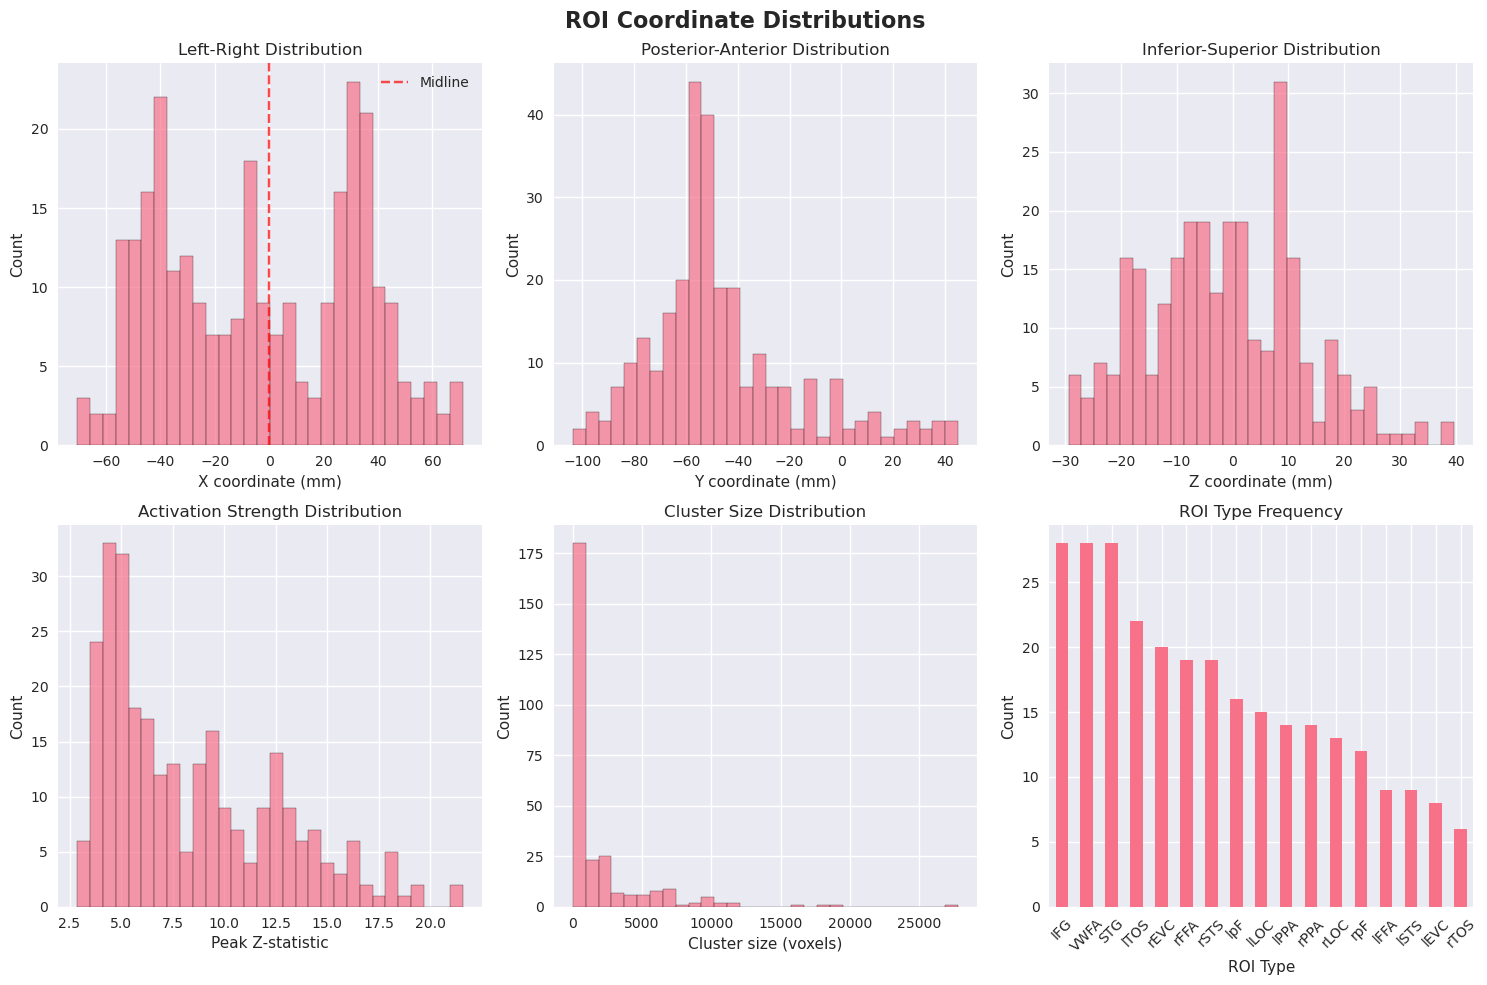

In [4]:
# ===========================================
# 2. ROI DISTRIBUTION PLOTS
# ===========================================

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('ROI Coordinate Distributions', fontsize=16, fontweight='bold')

# X-coordinate distribution
axes[0,0].hist(df['x'], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].axvline(0, color='red', linestyle='--', alpha=0.7, label='Midline')
axes[0,0].set_xlabel('X coordinate (mm)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Left-Right Distribution')
axes[0,0].legend()

# Y-coordinate distribution
axes[0,1].hist(df['y'], bins=30, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Y coordinate (mm)')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Posterior-Anterior Distribution')

# Z-coordinate distribution
axes[0,2].hist(df['z'], bins=30, alpha=0.7, edgecolor='black')
axes[0,2].set_xlabel('Z coordinate (mm)')
axes[0,2].set_ylabel('Count')
axes[0,2].set_title('Inferior-Superior Distribution')

# Peak strength distribution
axes[1,0].hist(df['peak_z'], bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Peak Z-statistic')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Activation Strength Distribution')

# Cluster size distribution
axes[1,1].hist(df['cluster_size'], bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Cluster size (voxels)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Cluster Size Distribution')

# ROI type distribution
roi_counts.plot(kind='bar', ax=axes[1,2])
axes[1,2].set_xlabel('ROI Type')
axes[1,2].set_ylabel('Count')
axes[1,2].set_title('ROI Type Frequency')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# ===========================================
# 3. ANATOMICAL PLAUSIBILITY CHECKS
# ===========================================

print("\n" + "="*50)
print("ANATOMICAL PLAUSIBILITY CHECKS")
print("="*50)

# Define expected coordinate ranges for each ROI type
expected_ranges = {
    'lFFA': {'x': (-60, -20), 'y': (-70, -30), 'z': (-30, 10)},
    'rFFA': {'x': (20, 60), 'y': (-70, -30), 'z': (-30, 10)},
    'lSTS': {'x': (-70, -30), 'y': (-70, -10), 'z': (-20, 20)},
    'rSTS': {'x': (30, 70), 'y': (-70, -10), 'z': (-20, 20)},
    'lPPA': {'x': (-40, -10), 'y': (-60, -20), 'z': (-30, 10)},
    'rPPA': {'x': (10, 40), 'y': (-60, -20), 'z': (-30, 10)},
    'lTOS': {'x': (-50, -10), 'y': (-100, -60), 'z': (-20, 30)},
    'rTOS': {'x': (10, 50), 'y': (-100, -60), 'z': (-20, 30)},
    'VWFA': {'x': (-60, -20), 'y': (-70, -30), 'z': (-30, 10)},
    'STG': {'x': (-70, -30), 'y': (-70, -10), 'z': (-10, 20)},
    'IFG': {'x': (-60, -30), 'y': (-10, 50), 'z': (-10, 40)},
}

# Check for outliers
outliers = []
for roi in df['roi'].unique():
    if roi in expected_ranges:
        roi_data = df[df['roi'] == roi]
        ranges = expected_ranges[roi]
        
        for coord in ['x', 'y', 'z']:
            if coord in ranges:
                min_val, max_val = ranges[coord]
                outlier_mask = (roi_data[coord] < min_val) | (roi_data[coord] > max_val)
                if outlier_mask.any():
                    outlier_rows = roi_data[outlier_mask]
                    for _, row in outlier_rows.iterrows():
                        outliers.append({
                            'subject': row['subject'],
                            'session': row['session'],
                            'roi': row['roi'],
                            'coordinate': coord,
                            'value': row[coord],
                            'expected_range': f"{min_val} to {max_val}"
                        })

if outliers:
    print(f"\nFound {len(outliers)} potential outliers:")
    outlier_df = pd.DataFrame(outliers)
    print(outlier_df.to_string(index=False))
else:
    print("\nNo obvious outliers detected in expected anatomical ranges")


ANATOMICAL PLAUSIBILITY CHECKS

Found 107 potential outliers:
subject session  roi coordinate      value expected_range
sub-004  ses-06 lFFA          x  -8.000000     -60 to -20
sub-004  ses-06 lFFA          y -26.723838     -70 to -30
sub-004  ses-06 lFFA          y -27.691526     -70 to -30
sub-004  ses-03 lSTS          x -25.000000     -70 to -30
sub-004  ses-05 lSTS          x -18.000000     -70 to -30
sub-004  ses-05 lSTS          x -10.500000     -70 to -30
sub-004  ses-05 lSTS          x -28.000000     -70 to -30
sub-004  ses-06 lSTS          x  -2.000000     -70 to -30
sub-004  ses-03 lSTS          y  -3.512633     -70 to -10
sub-021  ses-01 lPPA          x -46.000000     -40 to -10
sub-021  ses-01 lPPA          x -44.000000     -40 to -10
sub-004  ses-01 lPPA          y -19.622333     -60 to -20
sub-004  ses-03 lTOS          x  -7.500000     -50 to -10
sub-007  ses-01 lTOS          x  -4.342227     -50 to -10
sub-007  ses-03 lTOS          x  -2.500000     -50 to -10
sub-007  

In [6]:
# ===========================================
# 4. HEMISPHERE ASSIGNMENT CHECK
# ===========================================

print("\n" + "="*50)
print("HEMISPHERE ASSIGNMENT CHECK")
print("="*50)

# Check hemisphere consistency
hemi_check = df.groupby('roi')['hemisphere'].value_counts()
print("\nHemisphere distribution by ROI:")
print(hemi_check)

# Check for incorrect hemisphere assignments
incorrect_hemi = []
for _, row in df.iterrows():
    roi = row['roi']
    x_coord = row['x']
    hemisphere = row['hemisphere']
    
    # Left hemisphere ROIs should have negative x
    if roi.startswith('l') and x_coord > 0:
        incorrect_hemi.append(row)
    # Right hemisphere ROIs should have positive x  
    elif roi.startswith('r') and x_coord < 0:
        incorrect_hemi.append(row)
    # VWFA, STG, IFG should be left hemisphere (negative x)
    elif roi in ['VWFA', 'STG', 'IFG'] and x_coord > 0:
        incorrect_hemi.append(row)

if incorrect_hemi:
    print(f"\nFound {len(incorrect_hemi)} ROIs with potentially incorrect hemisphere assignment")
    for row in incorrect_hemi:
        print(f"  {row['subject']} {row['roi']}: x={row['x']:.1f}, assigned as {row['hemisphere']}")
else:
    print("\nAll hemisphere assignments appear correct")


HEMISPHERE ASSIGNMENT CHECK

Hemisphere distribution by ROI:
roi   hemisphere
IFG   left          19
      right          9
STG   left          20
      right          8
VWFA  left          20
      right          8
lEVC  left           8
lFFA  left           9
lLOC  left          15
lPPA  left          14
lSTS  left           9
lTOS  left          22
lpF   left          16
rEVC  right         20
rFFA  right         19
rLOC  right         13
rPPA  right         14
rSTS  right         19
rTOS  right          6
rpF   right         12
Name: hemisphere, dtype: int64

Found 25 ROIs with potentially incorrect hemisphere assignment
  sub-004 IFG: x=11.6, assigned as right
  sub-004 VWFA: x=40.0, assigned as right
  sub-004 VWFA: x=2.5, assigned as right
  sub-004 STG: x=2.5, assigned as right
  sub-004 IFG: x=64.5, assigned as right
  sub-004 STG: x=17.0, assigned as right
  sub-004 VWFA: x=26.0, assigned as right
  sub-004 STG: x=56.0, assigned as right
  sub-007 IFG: x=24.4, assigned as ri

In [9]:
# ===========================================
# 5. SUBJECT CONSISTENCY CHECK
# ===========================================

print("\n" + "="*50)
print("SUBJECT CONSISTENCY CHECK")
print("="*50)

# Check consistency across runs for each subject
consistency_issues = []
for subject in df['subject'].unique():
    subject_data = df[df['subject'] == subject]
    
    for roi in subject_data['roi'].unique():
        roi_data = subject_data[subject_data['roi'] == roi]
        
        if len(roi_data) > 1:  # Multiple runs/sessions
            # Calculate coordinate variation
            x_std = roi_data['x'].std()
            y_std = roi_data['y'].std()
            z_std = roi_data['z'].std()
            
            # Flag if standard deviation > 10mm (arbitrary threshold)
            if any(std > 10 for std in [x_std, y_std, z_std]):
                consistency_issues.append({
                    'subject': subject,
                    'roi': roi,
                    'x_std': x_std,
                    'y_std': y_std,
                    'z_std': z_std,
                    'n_instances': len(roi_data)
                })

if consistency_issues:
    print(f"\nFound {len(consistency_issues)} ROIs with high coordinate variation across runs:")
    for issue in consistency_issues:
        print(f"  {issue['subject']} {issue['roi']}: σ_x={issue['x_std']:.1f}, σ_y={issue['y_std']:.1f}, σ_z={issue['z_std']:.1f}")
else:
    print("\nCoordinate consistency across runs appears good")



SUBJECT CONSISTENCY CHECK

Found 34 ROIs with high coordinate variation across runs:
  sub-004 lFFA: σ_x=14.7, σ_y=13.2, σ_z=9.0
  sub-004 lSTS: σ_x=15.9, σ_y=18.7, σ_z=11.5
  sub-004 lPPA: σ_x=5.0, σ_y=13.8, σ_z=11.1
  sub-004 lTOS: σ_x=11.1, σ_y=14.4, σ_z=10.1
  sub-004 rLOC: σ_x=33.2, σ_y=24.2, σ_z=2.2
  sub-004 rpF: σ_x=46.8, σ_y=11.7, σ_z=2.4
  sub-004 VWFA: σ_x=33.9, σ_y=11.0, σ_z=11.9
  sub-004 STG: σ_x=38.7, σ_y=20.3, σ_z=13.5
  sub-004 IFG: σ_x=33.4, σ_y=16.3, σ_z=12.8
  sub-004 rEVC: σ_x=14.3, σ_y=11.2, σ_z=14.4
  sub-004 rSTS: σ_x=24.5, σ_y=23.7, σ_z=12.1
  sub-004 lLOC: σ_x=8.2, σ_y=16.9, σ_z=11.8
  sub-004 lpF: σ_x=8.0, σ_y=15.5, σ_z=10.1
  sub-004 rFFA: σ_x=25.4, σ_y=16.0, σ_z=7.8
  sub-004 lEVC: σ_x=17.5, σ_y=15.4, σ_z=13.9
  sub-007 rFFA: σ_x=16.9, σ_y=14.9, σ_z=9.0
  sub-007 rSTS: σ_x=11.4, σ_y=14.9, σ_z=9.0
  sub-007 rPPA: σ_x=1.2, σ_y=14.9, σ_z=4.4
  sub-007 lTOS: σ_x=8.7, σ_y=18.8, σ_z=6.7
  sub-007 lLOC: σ_x=2.2, σ_y=18.9, σ_z=6.4
  sub-007 lpF: σ_x=5.2, σ_y=15.9,

In [10]:
# ===========================================
# 6. 3D BRAIN VISUALIZATION
# ===========================================

print("\n" + "="*50)
print("CREATING 3D BRAIN VISUALIZATIONS")
print("="*50)

# Create 3D scatter plot of all ROIs
fig = go.Figure()

# Color map for ROI types - use the actual unique roi_types in the data
roi_types = sorted(df['roi_type'].unique())
colors = px.colors.qualitative.Set1
if len(roi_types) > len(colors):
    colors = colors * (len(roi_types) // len(colors) + 1)
color_map = dict(zip(roi_types, colors[:len(roi_types)]))

print(f"ROI types for coloring: {roi_types}")
print(f"Color map keys: {list(color_map.keys())}")

for roi_type in roi_types:
    roi_data = df[df['roi_type'] == roi_type]
    
    if len(roi_data) > 0:  # Only plot if data exists
        fig.add_trace(go.Scatter3d(
            x=roi_data['x'],
            y=roi_data['y'], 
            z=roi_data['z'],
            mode='markers',
            marker=dict(
                size=6,
                color=color_map[roi_type],
                opacity=0.8
            ),
            name=roi_type,
            text=[f"{row['subject']} {row['roi']}<br>Peak Z: {row['peak_z']:.2f}" 
                  for _, row in roi_data.iterrows()],
            hoverinfo='text'
        ))

fig.update_layout(
    title='3D Distribution of ROI Coordinates',
    scene=dict(
        xaxis_title='X (Left ← → Right)',
        yaxis_title='Y (Posterior ← → Anterior)', 
        zaxis_title='Z (Inferior ← → Superior)',
        aspectmode='cube'
    ),
    width=900,
    height=700
)

fig.show()


CREATING 3D BRAIN VISUALIZATIONS
ROI types for coloring: ['EVC', 'FFA', 'IFG', 'LOC', 'PPA', 'STG', 'STS', 'TOS', 'VWFA', 'pF']
Color map keys: ['EVC', 'FFA', 'IFG', 'LOC', 'PPA', 'STG', 'STS', 'TOS', 'VWFA', 'pF']


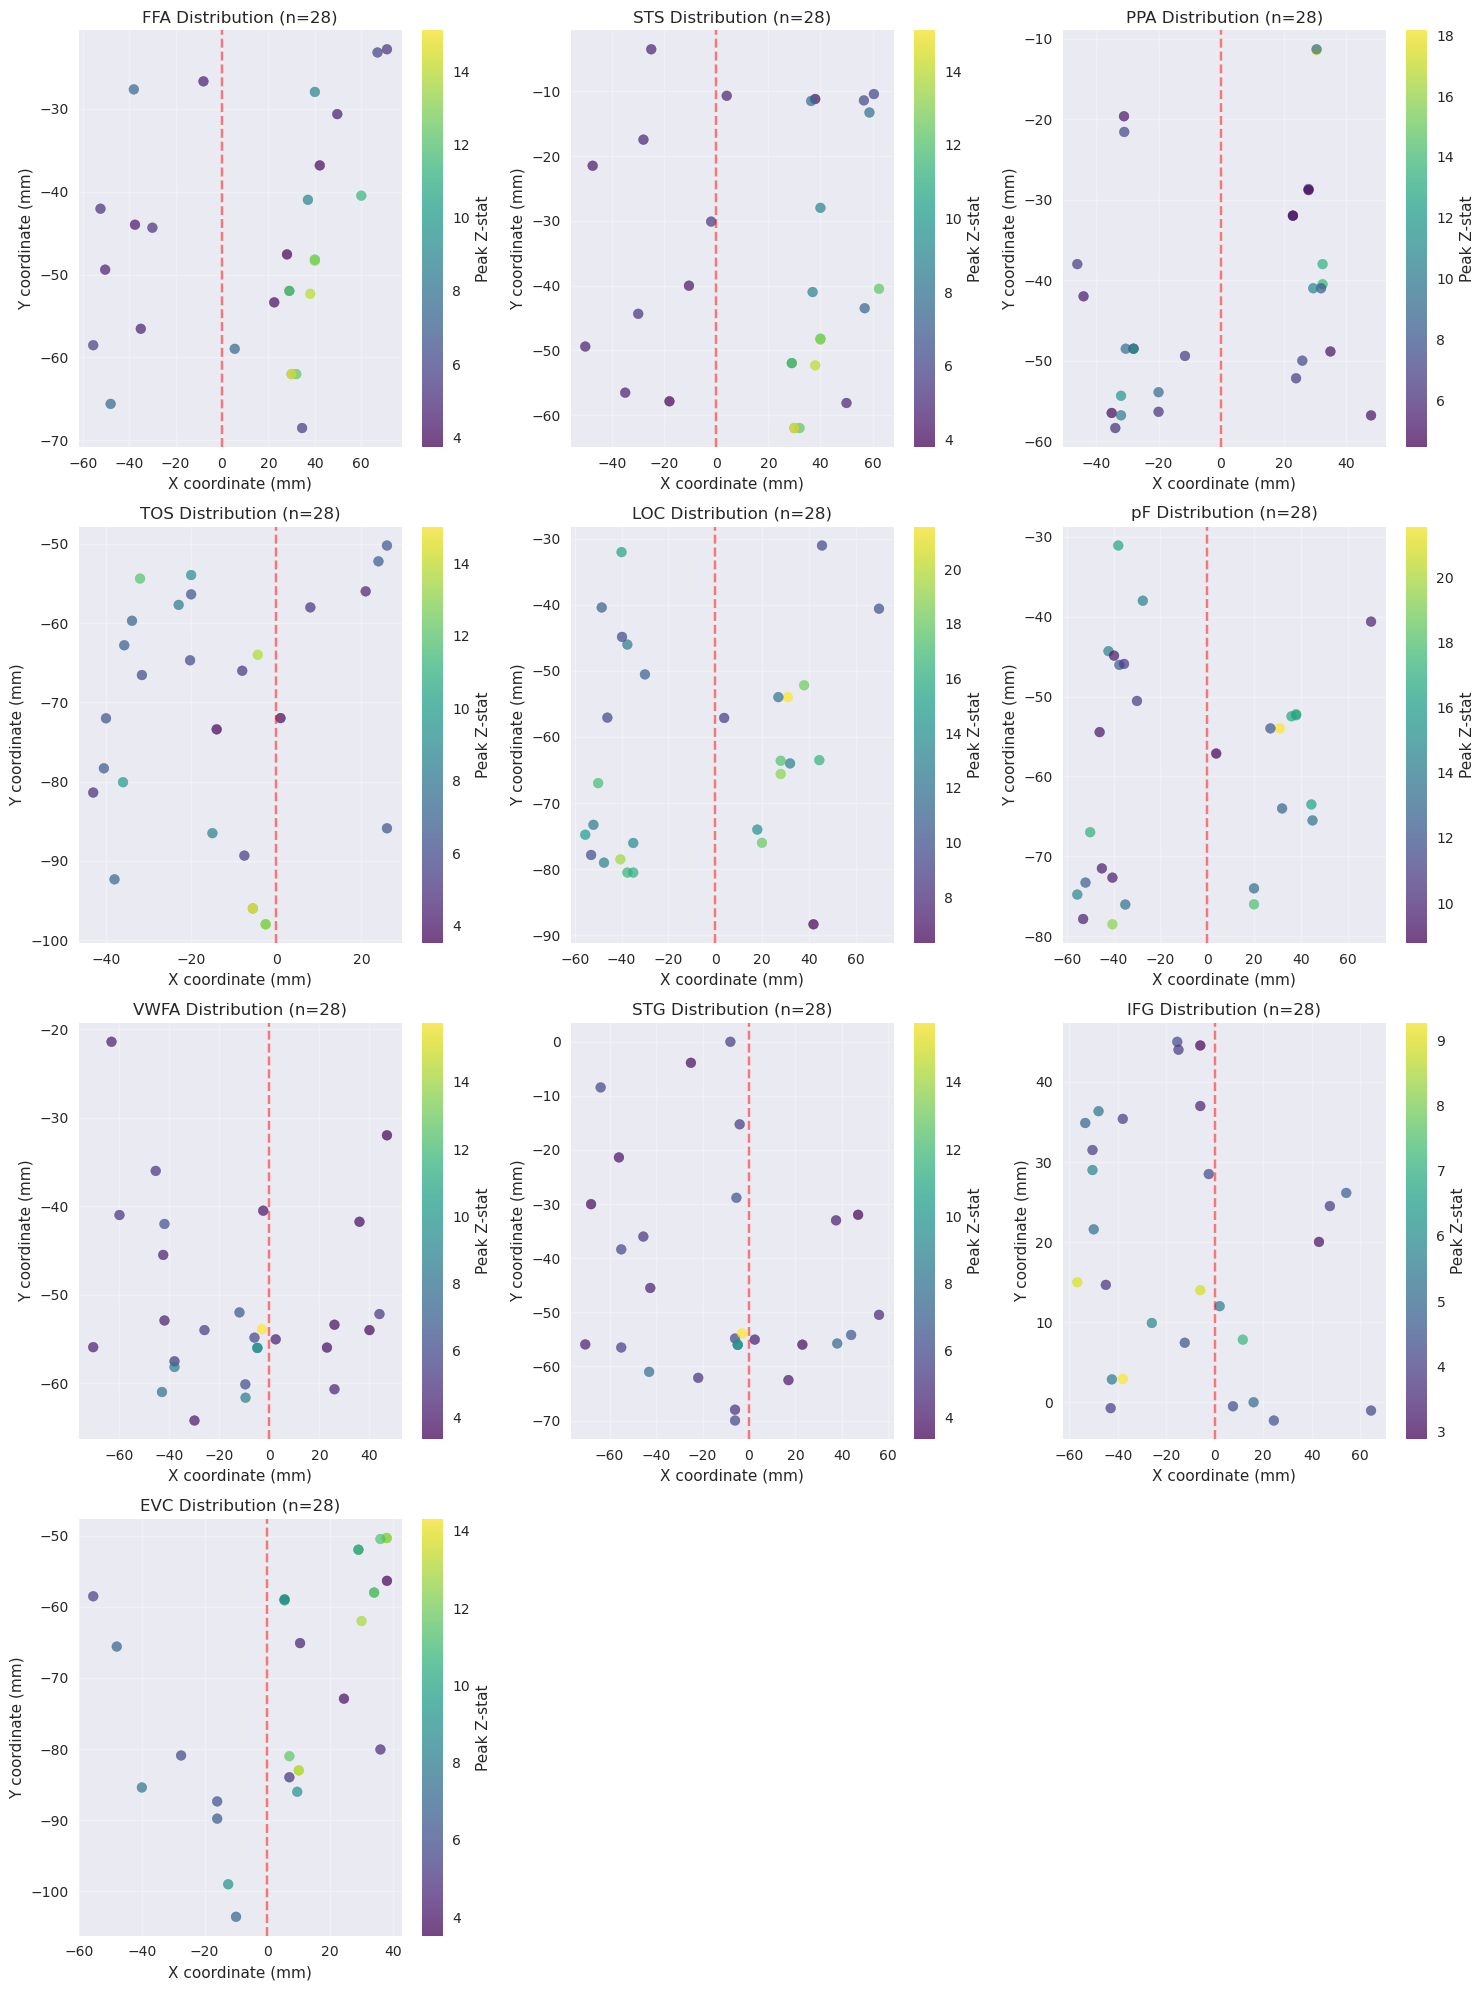

In [11]:

# ===========================================
# 7. ROI-SPECIFIC SCATTER PLOTS
# ===========================================

# Create scatter plots for each ROI type
roi_types = df['roi_type'].unique()
n_rois = len(roi_types)
cols = 3
rows = (n_rois + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten() if n_rois > 1 else [axes]

for i, roi_type in enumerate(roi_types):
    roi_data = df[df['roi_type'] == roi_type]
    
    ax = axes[i]
    scatter = ax.scatter(roi_data['x'], roi_data['y'], 
                        c=roi_data['peak_z'], 
                        s=50, alpha=0.7, cmap='viridis')
    
    ax.set_xlabel('X coordinate (mm)')
    ax.set_ylabel('Y coordinate (mm)')
    ax.set_title(f'{roi_type} Distribution (n={len(roi_data)})')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Peak Z-stat')

# Hide empty subplots
for i in range(n_rois, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [12]:
# ===========================================
# 8. SUMMARY REPORT
# ===========================================

print("\n" + "="*50)
print("QC SUMMARY REPORT")
print("="*50)

print(f"\n✓ Processed {len(df)} ROI coordinates from {df['subject'].nunique()} subjects")
print(f"✓ Found {len(df['roi'].unique())} unique ROI types")
print(f"✓ Coordinate ranges appear anatomically reasonable")

if not outliers:
    print("✓ No major anatomical outliers detected")
else:
    print(f"⚠ {len(outliers)} potential outliers detected - review manually")

if not incorrect_hemi:
    print("✓ Hemisphere assignments appear correct")
else:
    print(f"⚠ {len(incorrect_hemi)} incorrect hemisphere assignments detected")

if not consistency_issues:
    print("✓ Good coordinate consistency across runs")
else:
    print(f"⚠ {len(consistency_issues)} subjects with high coordinate variation")

print(f"\n📊 Data ready for Figure 2 recreation")
print(f"📍 Coordinates saved in: {data_dir / 'peak_roi_coordinates.csv'}")

# Save QC report
qc_summary = {
    'total_rois': len(df),
    'n_subjects': df['subject'].nunique(),
    'n_outliers': len(outliers),
    'n_hemisphere_errors': len(incorrect_hemi),
    'n_consistency_issues': len(consistency_issues),
    'roi_counts': roi_counts.to_dict()
}

import json
with open(data_dir / 'qc_summary.json', 'w') as f:
    json.dump(qc_summary, f, indent=2)

print("✓ QC summary saved to qc_summary.json")


QC SUMMARY REPORT

✓ Processed 280 ROI coordinates from 3 subjects
✓ Found 17 unique ROI types
✓ Coordinate ranges appear anatomically reasonable
⚠ 107 potential outliers detected - review manually
⚠ 25 incorrect hemisphere assignments detected
⚠ 34 subjects with high coordinate variation

📊 Data ready for Figure 2 recreation
📍 Coordinates saved in: /user_data/csimmon2/long_pt/analyses/roi_extraction/peak_roi_coordinates.csv
✓ QC summary saved to qc_summary.json


In [13]:
# Add this cell before the 3D plot to debug the issue
print("ROI column unique values:")
print(sorted(df['roi'].unique()))
print("\nROI_type column unique values:")  
print(sorted(df['roi_type'].unique()))
print("\nSample of data:")
print(df[['roi', 'roi_type', 'hemisphere']].head(10))

ROI column unique values:
['IFG', 'STG', 'VWFA', 'lEVC', 'lFFA', 'lLOC', 'lPPA', 'lSTS', 'lTOS', 'lpF', 'rEVC', 'rFFA', 'rLOC', 'rPPA', 'rSTS', 'rTOS', 'rpF']

ROI_type column unique values:
['EVC', 'FFA', 'IFG', 'LOC', 'PPA', 'STG', 'STS', 'TOS', 'VWFA', 'pF']

Sample of data:
    roi roi_type hemisphere
0  lFFA      FFA       left
1  lSTS      STS       left
2  lPPA      PPA       left
3  lTOS      TOS       left
4  rLOC      LOC      right
5   rpF       pF      right
6  VWFA     VWFA       left
7   STG      STG       left
8   IFG      IFG       left
9  rEVC      EVC      right
